In [1]:
from torchsummary import summary
import os
import pandas as pd
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from sklearn.model_selection import train_test_split
import wandb
import albumentations as A
from utils.seg_dataset import SegmentationDataset
from utils.custom_dataset import CustomDataset
import segmentation_models_pytorch as smp

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_dir_path="./data/train/train/"
label_dir_path="./data/train_gt/train_gt/"

In [4]:
transform=Compose([Resize((256,256),interpolation=InterpolationMode.BILINEAR),
                   PILToTensor()])

In [5]:
dataset=SegmentationDataset(train_dir_path,label_dir_path,transform)

In [ ]:
TRAIN_SIZE=0.8
VAL_SIZE=0.2
BATCH_SIZE=4
img_data=[]
label_data=[]

In [7]:
for x,y in dataset:
    img_data.append(x)
    label_data.append(y)

In [14]:
temp_X_train,temp_X_val,temp_y_train,temp_y_val=train_test_split(img_data,label_data,test_size=0.2,random_state=10)

In [15]:
print(len(temp_X_train))
print(len(temp_X_val))

800
200


In [16]:
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=0.01, g_shift_limit=0.01, b_shift_limit=0.01),
])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6832\3189059247.py:4: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),


In [17]:
train_set=CustomDataset(temp_X_train,temp_y_train,aug=augmentation)
val_set=CustomDataset(temp_X_val,temp_y_val,aug=None)

In [20]:
t=train_set[1][0]
t

tensor([[[0.0051, 0.0051, 0.0051,  ..., 0.0051, 0.0051, 0.0051],
         [0.0051, 0.0051, 0.0051,  ..., 0.0051, 0.0051, 0.0051],
         [0.0051, 0.0051, 0.0051,  ..., 0.1816, 0.0169, 0.0051],
         ...,
         [0.0051, 0.0051, 0.0051,  ..., 0.0051, 0.0051, 0.0051],
         [0.0051, 0.0051, 0.0051,  ..., 0.0051, 0.0051, 0.0051],
         [0.0051, 0.0051, 0.0051,  ..., 0.0051, 0.0051, 0.0051]],

        [[0.0138, 0.0138, 0.0138,  ..., 0.0138, 0.0138, 0.0138],
         [0.0138, 0.0138, 0.0138,  ..., 0.0138, 0.0138, 0.0138],
         [0.0138, 0.0138, 0.0138,  ..., 0.1903, 0.0256, 0.0138],
         ...,
         [0.0138, 0.0138, 0.0138,  ..., 0.0138, 0.0138, 0.0138],
         [0.0138, 0.0138, 0.0138,  ..., 0.0138, 0.0138, 0.0138],
         [0.0138, 0.0138, 0.0138,  ..., 0.0138, 0.0138, 0.0138]],

        [[0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
         [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
         [0.0059, 0.0059, 0.0059,  ..., 0.1823, 0.0176, 0.

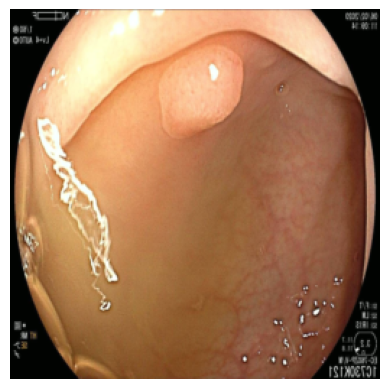

In [21]:
image = t.permute(1, 2, 0).numpy()

# Step 2: Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axis for cleaner display
plt.show()

In [22]:
train_dataloader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader=DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=True)

In [23]:
model=smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3   
)

In [24]:
wandb.init(
    project="Polyp Detection",
    resume="allow",
)
wandb.watch(model)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nzd (nzd-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin


[]

In [37]:
EPOCH=10
lr=0.01
PATH="model/model.pth"

In [26]:
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=lr)
scheduler=optim.lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=0.2,total_iters=10)

In [38]:
def train():
    best_val_loss=999
    for epoch in range(EPOCH):
        model.train()
        train_loss=0
        start_time=time.time()
        for i,(data,target) in enumerate(train_dataloader):
            data,target=data.to(device),target.to(device)
            output=model(data)
            loss=criterion(output,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
        time_taken=time.time()-start_time
        model.eval()
        val_loss=0
        with torch.no_grad():
            for i,(data,target) in enumerate(val_dataloader):
                data,target=data.to(device),target.to(device)
                output=model(data)
                loss=criterion(output,target)
                val_loss+=loss.item()
        train_loss=train_loss/len(train_dataloader.dataset)
        val_loss=val_loss/len(val_dataloader.dataset)
        print(f"Done epoch {epoch}: | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Time taken: {time_taken:.4f} |")
        if val_loss<best_val_loss:
            best_val_loss=val_loss
            checkpoint={
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': val_loss,
            }
            torch.save(checkpoint,PATH)
        wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        })
    wandb.finish()

In [39]:
train()

Done epoch 0: | Train loss: 0.0422 | Val loss: 0.0420 | Time taken: 17.1707 |
Done epoch 1: | Train loss: 0.0406 | Val loss: 0.0438 | Time taken: 16.9286 |
Done epoch 2: | Train loss: 0.0403 | Val loss: 0.0440 | Time taken: 17.0811 |
Done epoch 3: | Train loss: 0.0393 | Val loss: 0.0485 | Time taken: 16.8849 |
Done epoch 4: | Train loss: 0.0393 | Val loss: 0.0432 | Time taken: 16.8618 |
Done epoch 5: | Train loss: 0.0381 | Val loss: 0.0468 | Time taken: 16.8166 |
Done epoch 6: | Train loss: 0.0366 | Val loss: 0.0380 | Time taken: 16.8292 |
Done epoch 7: | Train loss: 0.0369 | Val loss: 0.0370 | Time taken: 17.1130 |
Done epoch 8: | Train loss: 0.0357 | Val loss: 0.0374 | Time taken: 20.6606 |
Done epoch 9: | Train loss: 0.0350 | Val loss: 0.0366 | Time taken: 16.9375 |


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▆▅▅▄▃▃▂▁
val_loss,▄▅▅█▅▇▂▁▁▁
epoch,9
train_loss,0.03504
val_loss,0.03661
